In [20]:
pip install ifcopenshell

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
import ifcopenshell

# Load an IFC file
#file_path = 'DummyModel.ifc'
file_path = 'Open.ifc'
model = ifcopenshell.open(file_path)
print(model.schema)

IFC2X3


In [22]:
import multiprocessing
import ifcopenshell
import ifcopenshell.geom

tree = ifcopenshell.geom.tree()
settings = ifcopenshell.geom.settings()
iterator = ifcopenshell.geom.iterator(settings, model, multiprocessing.cpu_count())
if iterator.initialize():
    while True:
        # Use triangulation to build a BVH tree
        tree.add_element(iterator.get())

        # Alternatively, use this code to build an unbalanced binary tree
        # tree.add_element(iterator.get_native())

        if not iterator.next():
            break

In [23]:
model.by_type("IfcColumn")

[#1272=IfcColumn('3BCWkUnn5CcQHYl8jbVpYV',#45,'COLUMN','400x400',$,#1271,#1268,'C-0(?)'),
 #1302=IfcColumn('1IzW11pqjB7R349Sk1pftp',#45,'COLUMN','400x400',$,#1301,#1298,'C-0(?)'),
 #1312=IfcColumn('0KPfSTfNLApxVB$d0dOV1r',#45,'COLUMN','400x400',$,#1311,#1308,'C-0(?)'),
 #1322=IfcColumn('0o5Fjs_uX57xBkeGeUpoSy',#45,'COLUMN','400x400',$,#1321,#1318,'C-0(?)'),
 #1330=IfcColumn('1RIf$YE4n4YRq5vSq2B5GE',#45,'COLUMN','400x400',$,#1329,#1326,'C-0(?)'),
 #1338=IfcColumn('0WdUesvb14muZIzwnNnrUn',#45,'COLUMN','400x400',$,#1337,#1334,'C-0(?)'),
 #1346=IfcColumn('2B0lfxDErCz9BtwCGuqCjK',#45,'COLUMN','400x400',$,#1345,#1342,'C-0(?)'),
 #1354=IfcColumn('06QR1Aq2TA4g2UntXBR2DP',#45,'COLUMN','400x400',$,#1353,#1350,'C-0(?)'),
 #2800=IfcColumn('2KaacCvLT00xg1249QrNxt',#45,'COLUMN','400x400',$,#2799,#2796,'C-0(?)'),
 #2810=IfcColumn('0_O05GxMH3s9UwnhkE9DKP',#45,'COLUMN','400x400',$,#2809,#2806,'C-0(?)'),
 #2820=IfcColumn('1eB91BgTjE3h0AVa9Ev9gw',#45,'COLUMN','400x400',$,#2819,#2816,'C-0(?)'),
 #2830=Ifc

In [24]:
clashes = tree.clash_intersection_many(
    #group_a_elements, # e.g. from model.by_type("IfcWall")
    #group_b_elements, # Group b can be the same as group a if you want to clash within a single set
    model.by_type("IfcColumn"),
    model.by_type("IfcBeam"),
    tolerance=0.002, # Any protrusions less than 2mm are ignored
    check_all=True, # Keep on checking all potential intersections to find a worst case protrusion distance
)

for clash in clashes:
    # Get the two elements that clash and their metadata
    element1 = clash.a
    element2 = clash.b
    a_global_id = element1.get_argument(0)
    b_global_id = element2.get_argument(0)
    a_ifc_class = element1.is_a()
    b_ifc_class = element2.is_a()
    a_name = element1.get_argument(2)
    b_name = element2.get_argument(2)

    # Potential clash types that can be detected are protrusions, pierces, and collisions
    clash_type = ["protrusion", "pierce", "collision", "clearance"][clash.clash_type],

    # P1 and P2 represents two XYZ coordinates. The meaning of the coordinate depends on the clash type.
    p1 = list(clash.p1)
    p2 = list(clash.p2)

    # This represents the protrusion or piercing distance in meters.
    # It is also the distance between P1 and P2.
    distance = clash.distance

In [25]:
len(clashes)

90

In [26]:
12*7

84

In [61]:
# Assuming `clashes[0]` is a valid clash object and has the appropriate methods/attributes
clash = clashes[0]

# Get the IDs of the elements involved in the clash
element_a_id = clash.a.id()
element_b_id = clash.b.id()

# Print the IDs
print(f"Element A ID: {element_a_id}")
print(f"Element B ID: {element_b_id}")

# Get the size (bounding box) of the elements
#element_a_size = clash.a.bounding_box()
#element_b_size = clash.b.bounding_box()

# Print the size (assuming bounding box returns dimensions or a dictionary)
#print(f"Element A Size: {element_a_size}")
#print(f"Element B Size: {element_b_size}")

# Get the material (assuming `material` or similar attribute/method exists)
element_a_material = clash.a.materials() if hasattr(clash.a, 'materials') else "Material not found"
element_b_material = clash.b.materials() if hasattr(clash.b, 'materials') else "Material not found"

# Print the materials
print(f"Element A Material: {element_a_material}")
print(f"Element B Material: {element_b_material}")


Element A ID: 106
Element B ID: 1322
Element A Material: Material not found
Element B Material: Material not found


In [66]:
model.by_id(106).GlobalId

'0ZWISPgWb95RvI9c59d4m6'

In [67]:
def get_material(element):
    material = None
    if element.HasAssociations:
        for assoc in element.HasAssociations:
            if assoc.is_a("IfcRelAssociatesMaterial"):
                material = assoc.RelatingMaterial.Name
                break
    return material

clash = clashes[0]
print(get_material(model.by_id(clash.a.id())))


CONCRETE/Concrete_Undefined


In [68]:
def get_sizes(element):
    sizes = {}
    if element.IsDefinedBy:
        for definition in element.IsDefinedBy:
            if definition.is_a("IfcRelDefinesByProperties"):
                prop_set = definition.RelatingPropertyDefinition
                if prop_set.is_a("IfcPropertySet"):
                    for prop in prop_set.HasProperties:
                        if prop.is_a("IfcPropertySingleValue"):
                            # Check for properties related to size (e.g., "Height", "Width", "Length")
                            if prop.Name in ["Height", "Width", "Length", "Depth"]:
                                sizes[prop.Name] = prop.NominalValue.wrappedValue
    return sizes

# Example usage:
clash = clashes[0]
print(get_sizes(model.by_id(clash.a.id())))

{'Height': 360.0, 'Width': 500.0, 'Length': 6000.0}


In [57]:
for i in [105,102,101,99,98,68,67,66,62,73,72,71,45]:
    print(model.by_id(i))

#105=IfcLocalPlacement(#46,#104)
#102=IfcProductDefinitionShape($,$,(#101))
#101=IfcShapeRepresentation(#12,'Body','Brep',(#99))
#99=IfcFacetedBrep(#98)
#98=IfcClosedShell((#68,#73,#78,#83,#88,#91,#94,#97))
#68=IfcFace((#67))
#67=IfcFaceOuterBound(#66,.T.)
#66=IfcPolyLoop((#62,#63,#64,#65))
#62=IfcCartesianPoint((0.,150.,-180.))
#73=IfcFace((#72))
#72=IfcFaceOuterBound(#71,.T.)
#71=IfcPolyLoop((#63,#69,#70,#64))
#45=IfcOwnerHistory(#3,#4,$,.NOCHANGE.,$,$,$,1730386800)


In [28]:
model.by_id(106).get_info()

{'id': 106,
 'type': 'IfcBeam',
 'GlobalId': '0ZWISPgWb95RvI9c59d4m6',
 'OwnerHistory': #45=IfcOwnerHistory(#3,#4,$,.NOCHANGE.,$,$,$,1730386800),
 'Name': 'BEAM',
 'Description': 'RCL300x360-500x150',
 'ObjectType': None,
 'ObjectPlacement': #105=IfcLocalPlacement(#46,#104),
 'Representation': #102=IfcProductDefinitionShape($,$,(#101)),
 'Tag': 'B-0(?)'}

In [32]:
elem = model.by_id(106)
import ifcopenshell.util
import ifcopenshell.util.element
data=ifcopenshell.util.element.get_psets(elem)

In [39]:
data

{'Tekla Common': {'Bottom elevation': ' +6.840',
  'Top elevation': ' +7.200',
  'Initial GUID': None,
  'Preliminary mark': '',
  'Phase': 1,
  'Class': '6',
  'id': 114},
 'Tekla Quantity': {'Weight': 1987.2,
  'Volume': 0.828,
  'Gross footprint area': 1.8,
  'Area per tons': 5.332,
  'Net surface area': 10.596,
  'Height': 360.0,
  'Width': 500.0,
  'Length': 6000.0,
  'id': 123},
 'Pset_BeamCommon': {'LoadBearing': False, 'Reference': 'B-0(?)', 'id': 126},
 'BaseQuantities': {'Length': 6000.0,
  'OuterSurfaceArea': 10.596,
  'NetVolume': 0.828,
  'NetWeight': 1987.2,
  'id': 131}}

In [38]:
elem.IsDefinedBy

(#3446=IfcRelDefinesByProperties('3j00yshUX9_Ox$xwtGtRlE',#5,$,$,(#247,#237,#227,#217,#209,#197,#152,#142,#106),#114),
 #3447=IfcRelDefinesByProperties('2oCwQ251f0aRMkLuhgkL2N',#5,$,$,(#329,#320,#311,#302,#294,#286,#278,#270,#258,#247,#237,#227,#217,#209,#197,#152,#142,#106),#123),
 #3448=IfcRelDefinesByProperties('2qU5$MrKr5N94fM2i62ZQL',#5,$,$,(#329,#320,#311,#302,#294,#286,#278,#270,#258,#247,#237,#227,#217,#209,#197,#152,#142,#106),#126),
 #3449=IfcRelDefinesByProperties('3K3eRF9xLCeuR0S7GR0GHo',#5,$,$,(#278,#270,#258,#152,#142,#106),#131),
 #3596=IfcRelDefinesByType('3xsRGqimT68Ru6pxsKfRUc',#5,$,$,(#278,#270,#258,#152,#142,#106),#107))

In [60]:
elem.GlobalId

'0ZWISPgWb95RvI9c59d4m6'

In [41]:
print(model.traverse(elem))
# Or, let's just go down one level deep
print(model.traverse(elem, max_levels=1))

[#106=IfcBeam('0ZWISPgWb95RvI9c59d4m6',#45,'BEAM','RCL300x360-500x150',$,#105,#102,'B-0(?)'), #45=IfcOwnerHistory(#3,#4,$,.NOCHANGE.,$,$,$,1730386800), #3=IfcPersonAndOrganization(#1,#2,$), #1=IfcPerson('PEIKKO\pillisam','Undefined',$,$,$,$,$,$), #2=IfcOrganization($,'Trimble Solutions Corporation',$,$,$), #4=IfcApplication(#2,'2023 Service Pack 7','Tekla Structures Partner','Multi material modeling'), #105=IfcLocalPlacement(#46,#104), #46=IfcLocalPlacement(#43,#10), #43=IfcLocalPlacement(#41,#10), #41=IfcLocalPlacement(#38,#10), #38=IfcLocalPlacement($,#10), #10=IfcAxis2Placement3D(#6,#9,#7), #6=IfcCartesianPoint((0.,0.,0.)), #9=IfcDirection((0.,0.,1.)), #7=IfcDirection((1.,0.,0.)), #104=IfcAxis2Placement3D(#103,#9,#8), #103=IfcCartesianPoint((36000.,12000.,7020.)), #8=IfcDirection((0.,1.,0.)), #102=IfcProductDefinitionShape($,$,(#101)), #101=IfcShapeRepresentation(#12,'Body','Brep',(#99)), #12=IfcGeometricRepresentationSubContext('Body','Model',*,*,*,*,#11,$,.MODEL_VIEW.,$), #11=IfcG

In [10]:
for clash in clashes:
    # Existing code to extract clash details
    element1 = clash.a
    element2 = clash.b

    # Retrieve geometry data (pseudo-code)
   # geom1 = element1.get_geometry()  # Replace with actual method to access geometry
    #geom2 = element2.get_geometry()  # Replace with actual method to access geometry

    # Analyze or visualize the clash
    # Use visualization libraries or geometry processing to highlight `p1` and `p2`
    
    # Print or process the coordinates of the clash
    print(f"Clash detected between {element1.is_a()} and {element2.is_a()}:")
    p1 = list(clash.p1)
    p2 = list(clash.p2)
# The ID of the element we processed
#print("id ", shape.id)
    print(f"  Closest points: {p1} and {p2}")
    print(f"  Distance: {clash.distance:.3f} meters")

Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.15, 18.0, 6.99] and [36.15, 18.2, 6.99]
  Distance: 0.200 meters
Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.15, 18.0, 3.39] and [36.150000000000006, 18.2, 3.39]
  Distance: 0.200 meters
Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.13, 12.0, 6.925] and [36.13, 12.2, 6.925]
  Distance: 0.200 meters
Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.15, 12.0, 6.99] and [36.15, 12.2, 6.99]
  Distance: 0.200 meters
Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.15, 12.0, 6.99] and [36.15, 12.2, 6.99]
  Distance: 0.200 meters
Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.15, 12.0, 3.39] and [36.150000000000006, 12.2, 3.39]
  Distance: 0.200 meters
Clash detected between IfcBeam and IfcColumn:
  Closest points: [36.15, 12.0, 3.39] and [36.150000000000006, 12.2, 3.39]
  Distance: 0.200 meters
Clash detected between IfcBe

clashes

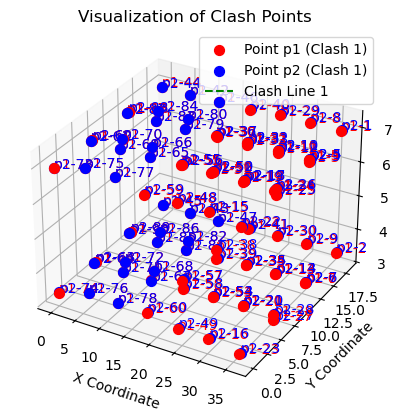

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume `clashes` is a list of clash objects obtained from the clash detection
# Each `clash` object has `p1` and `p2` properties representing the closest points

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop over each clash and plot the points
for i, clash in enumerate(clashes):
    p1 = list(clash.p1)  # Replace with actual clash.p1 data
    p2 = list(clash.p2)  # Replace with actual clash.p2 data

    # Plot the clash points
    ax.scatter(*p1, color='red', s=50, label=f'Point p1 (Clash {i+1})' if i == 0 else "")
    ax.scatter(*p2, color='blue', s=50, label=f'Point p2 (Clash {i+1})' if i == 0 else "")

    # Draw a line between the points to visualize the distance
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='green', linestyle='--', label=f'Clash Line {i+1}' if i == 0 else "")

    # Annotate the points for clarity
    ax.text(*p1, f'p1-{i+1}', color='red')
    ax.text(*p2, f'p2-{i+1}', color='blue')

# Set plot labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Visualization of Clash Points')

# Show legend and plot
ax.legend()
plt.show()


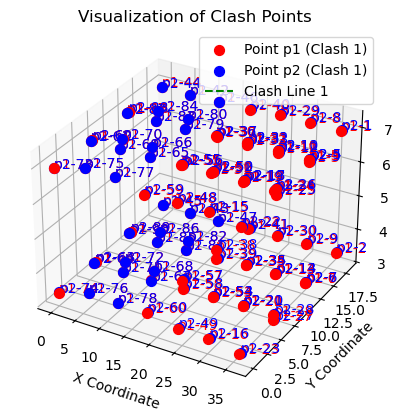

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode for rotatable plots
plt.ion()

# Assume `clashes` is a list of clash objects obtained from the clash detection
# Each `clash` object has `p1` and `p2` properties representing the closest points

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop over each clash and plot the points
for i, clash in enumerate(clashes):
    p1 = list(clash.p1)  # Replace with actual clash.p1 data
    p2 = list(clash.p2)  # Replace with actual clash.p2 data

    # Plot the clash points
    ax.scatter(*p1, color='red', s=50, label=f'Point p1 (Clash {i+1})' if i == 0 else "")
    ax.scatter(*p2, color='blue', s=50, label=f'Point p2 (Clash {i+1})' if i == 0 else "")

    # Draw a line between the points to visualize the distance
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='green', linestyle='--', label=f'Clash Line {i+1}' if i == 0 else "")

    # Annotate the points for clarity
    ax.text(*p1, f'p1-{i+1}', color='red')
    ax.text(*p2, f'p2-{i+1}', color='blue')

# Set plot labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Visualization of Clash Points')

# Show legend and plot
ax.legend()
plt.show()

# Keep the plot open and interactive
plt.ioff()  # Optional: Disable interactive mode if you don't need it afterward
